In [1]:
import numpy as np
import pandas as pd 
import pylab as plt
from types import SimpleNamespace
import statsmodels.api as sm
from tqdm.notebook import tqdm, trange

In [2]:
C = SimpleNamespace(
    n_observed_confounders = 3,
    n_unobserved_confounders = 0,
    true_effect_range = np.linspace(0.0, 0.1, 100),
    n_treated = 10000,
    n_samples = 100000,
    share_variant = 0.5,
)

In [3]:
def generate_data(true_effect_size):
    X_observed = np.random.randn(C.n_samples, C.n_observed_confounders)
    X_unobserved = np.random.randn(C.n_samples, C.n_unobserved_confounders)
    alpha_observed = np.random.randn(C.n_observed_confounders)
    alpha_unobserved = np.random.randn(C.n_unobserved_confounders)
    beta_observed = np.random.randn(C.n_observed_confounders)
    beta_unobserved = np.random.randn(C.n_unobserved_confounders)
    is_variant = np.random.randn(C.n_samples) < 0.5

    log_odds_treated = (
        X_observed @ alpha_observed +
        X_unobserved @ alpha_unobserved
    )
    would_be_treated_idx = np.argsort(log_odds_treated)[:C.n_treated]

    would_have_been_treated = np.zeros(C.n_samples, dtype=bool)
    would_have_been_treated[would_be_treated_idx] = True
    is_treated = is_variant & would_have_been_treated

    y = X_observed @ beta_observed + X_unobserved @ beta_unobserved
    y[is_treated] += true_effect_size

    data = SimpleNamespace(
        is_variant=is_variant,
        X_observed=X_observed,
        y=y,
        is_treated=is_treated,
        would_have_been_treated=would_have_been_treated
    )
    return data

In [4]:
# Simple method
def is_significant_no_adjustment(data):
    X = sm.add_constant(data.is_variant.astype(int))
    simple_model = sm.OLS(data.y, X)
    simple_results = simple_model.fit()
    return simple_results._results.pvalues[1] < 0.1

In [5]:
# Idealized method
def is_significant_ideal(data):
    X = sm.add_constant(data.is_variant[data.would_have_been_treated].astype(int))
    ideal_model = sm.OLS(data.y[data.would_have_been_treated], X)
    ideal_results = ideal_model.fit()
    return ideal_results._results.pvalues[1] < 0.1

In [6]:
def simulate_power(true_effect_size, n_samples, is_significant_method, verbose=True):
    
    if verbose:
        iterable = trange(n_samples, leave=False)
    else:
        iterable = range(n_samples)
    results = list(map(lambda x: is_significant_method(generate_data(true_effect_size)), iterable))
    return np.mean(results)


In [7]:
def power_vs_effect_size(effect_size_array, n_samples, is_significant_method):
    results = np.array(list(map(
        lambda x: simulate_power(x, n_samples, is_significant_method, verbose=False), 
        tqdm(effect_size_array, leave=False)
    )))
    return results

In [8]:
simple_power = power_vs_effect_size(C.true_effect_range, n_samples=100, is_significant_method=is_significant_no_adjustment)
print(simple_power)

  0%|          | 0/100 [00:00<?, ?it/s]

[0.09 0.13 0.12 0.1  0.09 0.04 0.1  0.11 0.04 0.14 0.09 0.14 0.08 0.14
 0.11 0.15 0.08 0.1  0.13 0.1  0.12 0.15 0.13 0.14 0.05 0.16 0.11 0.13
 0.13 0.1  0.16 0.11 0.1  0.19 0.11 0.14 0.1  0.12 0.19 0.17 0.13 0.15
 0.18 0.21 0.13 0.16 0.14 0.21 0.11 0.16 0.16 0.19 0.15 0.18 0.15 0.23
 0.16 0.19 0.24 0.27 0.21 0.23 0.24 0.27 0.19 0.2  0.17 0.19 0.19 0.25
 0.26 0.17 0.21 0.27 0.28 0.19 0.23 0.36 0.19 0.2  0.27 0.34 0.25 0.24
 0.18 0.33 0.23 0.26 0.26 0.23 0.23 0.26 0.27 0.23 0.28 0.32 0.3  0.24
 0.28 0.26]


In [10]:
ideal_power = power_vs_effect_size(C.true_effect_range, n_samples=100, is_significant_method=is_significant_ideal)
print(ideal_power)

  0%|          | 0/100 [00:00<?, ?it/s]

[0.11 0.09 0.14 0.1  0.07 0.11 0.1  0.11 0.15 0.13 0.14 0.11 0.21 0.14
 0.2  0.21 0.23 0.27 0.23 0.23 0.29 0.27 0.33 0.29 0.29 0.31 0.26 0.36
 0.35 0.43 0.4  0.45 0.43 0.43 0.44 0.45 0.46 0.43 0.53 0.48 0.49 0.51
 0.52 0.52 0.67 0.5  0.54 0.7  0.71 0.64 0.65 0.67 0.63 0.62 0.67 0.67
 0.62 0.65 0.74 0.71 0.75 0.8  0.72 0.72 0.79 0.7  0.77 0.74 0.79 0.86
 0.79 0.79 0.72 0.79 0.83 0.8  0.82 0.73 0.68 0.8  0.82 0.87 0.88 0.83
 0.78 0.87 0.84 0.87 0.85 0.92 0.86 0.84 0.86 0.9  0.89 0.82 0.84 0.85
 0.92 0.83]


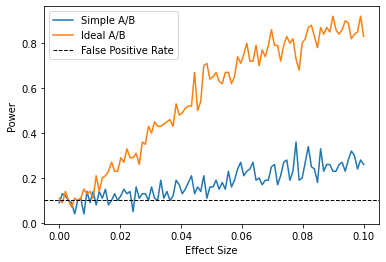

In [11]:
plt.plot(C.true_effect_range, simple_power, label="Simple A/B")
plt.plot(C.true_effect_range, ideal_power, label="Ideal A/B")
plt.axhline(0.1, color="k", lw=1, ls="--", label="False Positive Rate")
plt.legend()
plt.xlabel("Effect Size")
plt.ylabel("Power")
plt.show()